# Project Phases

1. Split dataset into train and test.
2. Convert dataset notes into one-hot-encoded classification labels.
3. Convert fingerprint images into 4D Tensors in the form _(nb_samples, 512, 512, 1)_.
4. Model and compile a vanilla NN architecture (model_nn).
5. Model and compile the CNN architecture with patches: 8, 16 and 32 (model_cnn1).
6. Model and compile the CNN architecture with patches: 16, 32 and 64 (model_cnn2).
7. Training function that computes and plots results
    1. Parameters for epochs, learning rate, batch size
    2. Load the model with the best validation loss
    3. Compute the accuracy of the model
8. X Train the model_nn with default hyperparameters
9. X Train the model_cnn1 with default hyperparameters
10. X Train the model_cnn2 with default hyperparameters
11. X Based on the best model, tune the hyperparameters
11. X Based on the best model, take some predictions

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Using TensorFlow backend.


## Phase 1: Split dataset into train and test

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df['path'], df['target'], test_size=0.3, random_state=42)

## Phase 2: Convert dataset notes into one-hot-encoded classification labels

In [4]:
label = { 'A': 1, 'T': 2, 'R': 3, 'W': 4, 'L': 0 }
num_classes = len(label)

In [5]:
y_train = [ label[c] for c in y_train ]
y_test = [ label[c] for c in y_test ]

In [6]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## Phase 3: Convert fingerprint images into 4D Tensors

In [7]:
from keras.preprocessing import image

In [8]:
def tensorfy(img_path):
    img = image.load_img(img_path, grayscale=True, target_size=(512, 512))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [9]:
def tensorfyList(img_path_list):
    list_of_tensors = [tensorfy(img_path) for img_path in img_path_list]
    return np.vstack(list_of_tensors)

In [10]:
X_train = tensorfyList(X_train)
X_test = tensorfyList(X_test)

## Phase 4: Model and compile a vanilla NN architecture (model_nn)

In [26]:
model_nn = Sequential()
model_nn.add(Flatten(input_shape=(512, 512, 1)))
model_nn.add(Dense(100, activation='relu'))
model_nn.add(Dense(100, activation='relu'))
model_nn.add(Dense(5, activation='softmax'))
model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               26214500  
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 505       
Total params: 26,225,105
Trainable params: 26,225,105
Non-trainable params: 0
_________________________________________________________________


## Phase 5: Model and compile the CNN architecture with patcher: 8, 16, 32 (model_cnn1)

In [16]:
model_cnn1 = Sequential()

model_cnn1.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(512, 512, 1)))
model_cnn1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn1.add(GlobalAveragePooling2D())

model_cnn1.add(Dense(100, activation='relu'))
model_cnn1.add(Dropout(0.2))

model_cnn1.add(Dense(5, activation='softmax'))

model_cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 512, 512, 8)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
__________

## Phase 6: Model and compile the CNN architecture with patches: 16, 32 and 64 (model_cnn2)

In [17]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(512, 512, 1)))
model_cnn2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn2.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

model_cnn2.add(GlobalAveragePooling2D())

model_cnn2.add(Dense(100, activation='relu'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Dense(5, activation='softmax'))

model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
__________

## Phase 7: Training function that computes and plots results

In [29]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from keras.optimizers import RMSprop

In [31]:
# Coding to plot loss and accuracy
# From https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

%matplotlib inline

from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

plot = PlotLearning()

In [44]:
# Coding to plot confusion matrix
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [45]:
def nist_train(model, checkpoint_path='best_model.hdf5', epochs=10, lr=0.001, batch_size=32):
    # compile the model with a given learning rate
    model.compile(optimizer=RMSprop(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # persist the best model on disk
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
    
    # stop if there is no improvement for a few epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    
    # train
    model.fit(X_train, y_train,
              validation_split=0.2, epochs=epochs, verbose=1, batch_size=batch_size,
              callbacks=[checkpointer, early_stopping, plot])
    
    # load the best model from disk
    model.load_weights(checkpoint_path)
    
    # compute the model's accuracy
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test]
    test_accuracy = 100 * np.sum(np.array(predictions) == np.argmax(y_test, axis=1)) / len(predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
    # compute and plot confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['L','A','T','R','W'],
                          normalize=True, title='Normalized confusion matrix')
    plt.show()


## Phase 8:  Train the model_nn with default hyperparameters

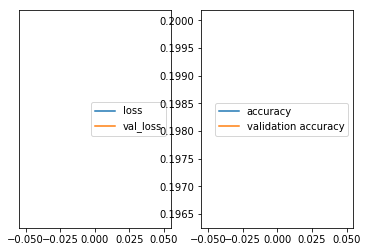

2240/2240 [==============================] - 8s - loss: 12.9520 - acc: 0.1964 - val_loss: 12.8945 - val_acc: 0.2000
Test accuracy: 20.0000%
Normalized confusion matrix
[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]]


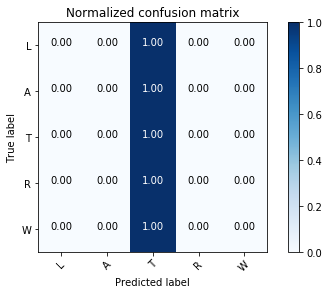

In [46]:
nist_train(model_nn, checkpoint_path='best_model_nn.hdf5', epochs=1)